In [1]:
from databases import Database
from sketch.api import data


database = Database(
    "sqlite+aiosqlite:///../../test.db",
)

pf = await data.get_portfolio(database, 'justin')

In [6]:
import pandas as pd
import json

test = pd.Series({k: json.dumps(v.to_dict()) for k, v in pf.sketchpads.items()})
test.to_parquet("349082_wikitable.parquet")

AttributeError: 'Series' object has no attribute 'to_parquet'

In [8]:
df = test.to_frame()

In [12]:
df.columns = ["sketchpad_data"]
df.index.name = "sketchpad_id"

In [18]:
df.to_parquet("349082_wikitable.parquet", compression="gzip")

In [19]:
!ls -lh 349082_wikitable.parquet

-rw-r--r--  1 jawaugh  staff   217M Aug 20 21:44 349082_wikitable.parquet


In [ ]:
# 300 MB -> 200 MB gzip compression on 349082 sketchpad scale


In [22]:
import numpy as np
import altair as alt
cards = np.array(
    [
        x.get_sketchdata_by_name("HyperLogLog").count()
        for x in pf.sketchpads.values()
    ]
)
# hist, bins = np.histogram(cards)
upper = pow(2, np.ceil(np.log(np.max(cards) / np.log(2))))
bins = np.geomspace(1, upper, num=100)
hist, *_ = np.histogram(cards, bins=bins)
# should be geometric mean...
df = pd.DataFrame({"x": bins[:-1], "x1": bins[1:], "y": hist})
chart = (
    alt.Chart(df)
    .mark_bar()
    .encode(
        x=alt.X(
            "x", title="Unique Count", scale=alt.Scale(type="log", domainMin=1)
        ),
        # x2="x2",
        # y=alt.Y("y", title="Number", scale=alt.Scale(type="log")),
        y=alt.Y("y", title="Count"),
    )
    .properties(width="container", height=300)
)

[-2.61468343 15.78566706]


/var/folders/9j/803_0r155ysbtyr6ybb3swxc0000gn/T/ipykernel_763/4176487695.py:17: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim([0, max(x)])
/var/folders/9j/803_0r155ysbtyr6ybb3swxc0000gn/T/ipykernel_763/4176487695.py:18: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim([0, max(y)])


[]

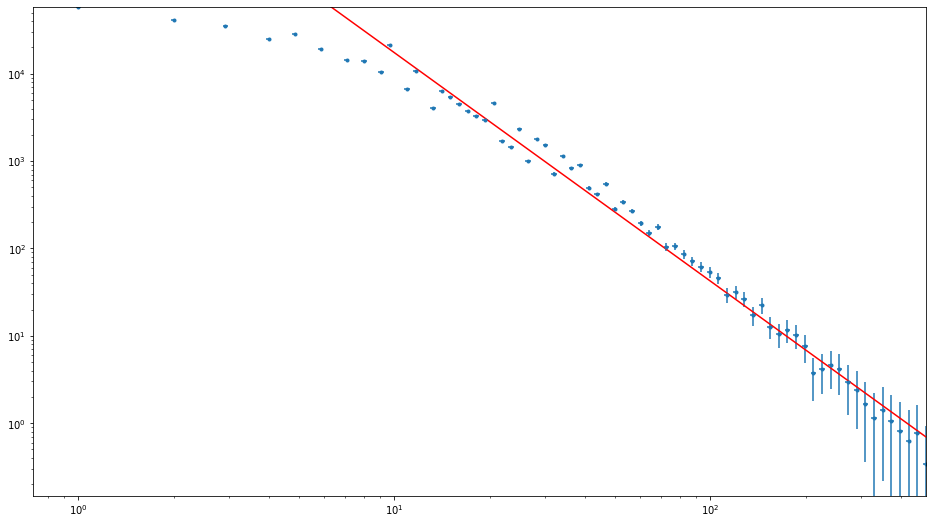

In [94]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 9))

x, y = zip(*[(x, y) for x, y in zip(df['x'], df['y']) if y > 0])
x, y = np.array(x), np.array(y)

y = y/np.array([1, *(x[1:] - x[:-1])])

plt.errorbar(x, y, xerr=0.02*x, yerr=np.sqrt(y), linestyle='None', marker='.')

# print(x, y)
z = np.polyfit(np.log(x[7:]), np.log(y[7:]), 1)
fit_data = np.poly1d(z)(np.log(x))
plt.loglog(x, np.exp(fit_data), 'r-',)
# plt.plot(x, np.exp(fit_data), 'r-',)
print(z)
plt.xlim([0, max(x)])
plt.ylim([0, max(y)])
plt.plot()

In [110]:
df = pd.DataFrame(zip(*[x, y, np.exp(fit_data)]), columns=['cardinality', 'count', 'fit'])
cardcount = lambda x: float(df.iloc[(df['cardinality'] - x).abs().argsort()[0],:]['count'])
cardcount_est = lambda x: float(df.iloc[(df['cardinality'] - x).abs().argsort()[0],:]['fit'])

In [115]:
for i in range(0, 10):
    print(i, 2**i, cardcount_est(2**(i))/cardcount_est(2**(i+1)), cardcount_est(2**i))

0 1 6.124887873350544 7171798.836741958
1 2 6.1248878733505325 1170927.367984406
2 4 6.124887873350544 191175.31491133515
3 8 6.1248878733505325 31212.86770703854
4 16 6.124887873350555 5096.071691833925
5 32 6.124887873350544 832.0269362002497
6 64 6.124887873350522 135.84361924736749
7 128 6.124887873350544 22.17895609786182
8 256 5.194500184122296 3.621120346441395
9 512 1.0 0.6971065969946151


In [116]:
3.621120346441395*(6.12**)

7126139.763390195

In [123]:
 (6.12**40)

2.9515958144921912e+31

In [101]:
# this was cool, co-pilot played along great here. 
# print(1, 2, 41616/32095)
# print(2, 4, 32095/23511)
# print(4, 8, 23511/11155)
# print(8, 16, 11155/4455)
# print(16, 32, 4455/1398) # co-pilot just guessed 4455/1331, but right answer is 1398 lol
# print(32, 64, 1398/590) # co pilot typed "32, 64, 1398/397" but right answer is 590 (??)
# print(64, 128, 590/273) # co pilot typed "64, 128, 590/273" but right answer is 273 (??)
# # i might have a flawed binning x-axis strategy... Need to think about that some more. 


In [ ]:
# Database consideration -> always have a parquet "rolling source" or something, something that is the serialized tape
#  -> its off of that (read many) that a bunch of things can be calculated.
#  -> can have lots of "named" rolling-sources. 

In [114]:
2**40

1099511627776